# 3. Time-Series Maker
Daniel Ruiz, MSc in Data Science and Business Analytics (DSBA), Bocconi University

Reference codes (alphabetically):
- https://stackoverflow.com/questions/33014025/pandas-assign-datetime-object-to-time-intervals

## 3.1. Loading packages

In [1]:
# general
import csv
import datetime
import pandas as pd
import pickle as pkl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## 3.2. Defining functions
### 3.2.1 Identidfy before-trading, trading, and after-trading; and hours blocks

- Datetime convention: all times are presented as GMT
- Twitter API data is GMT from origin
- Financial Market data is not GMT:
    - NY (NASDAQ/NYSE) is GMT - 5
    - SP (B3) is GMT - 3
- Daylight saving time:
    - Brazil doesn't have DST
    - US has DST from March 8th

In [2]:
def period_identifier(df,company):

    #-------------------------------------------------------------
    # input = (1) df that has a datetime column (string)
    #         (2) company name (string)
    #-------------------------------------------------------------
    # 1) loads data
    # 2) converts data to GMT (if necessary)
    # 3) adds block tags
    #-------------------------------------------------------------

    # 1) Load data
    df['datetime'] = pd.to_datetime(df.datetime)

    # 2) Convert to GMT
    df['datetime'] = df['datetime']
    
    #XXX
    # daylight saving time adjustment
    
    # 3) Add blocks
    
    # support variables
    df['date'] = df.datetime.dt.date
    df['date_adj'] = df.datetime.dt.date
    df['weekday']= df['datetime'].dt.weekday    
    
    # 15 minutes
    interv = 15
    df['interval_15'] = ((df['datetime'] - pd.TimedeltaIndex(df['datetime'].dt.minute % interv, 'm')) 
                      - pd.TimedeltaIndex(df['datetime'].dt.second , 's')).dt.time
    # 1 hour
    interv = 60
    df['interval_60'] = ((df['datetime'] - pd.TimedeltaIndex(df['datetime'].dt.minute % interv, 'm')) 
                      - pd.TimedeltaIndex(df['datetime'].dt.second , 's')).dt.time
    # blocks
    df['block_15'] = df.apply(lambda x: pd.Timestamp.combine(x['date'], x['interval_15']), axis=1)
    df['block_60'] = df.apply(lambda x: pd.Timestamp.combine(x['date'], x['interval_60']), axis=1)

    #################################################################################################
    # biz hours = weekday, not holiday, not pre-market, not after-market

    if company[:2]=='us':
        # holiday
        df['holiday'] = np.where(df['date_adj']==datetime.date(2020,1,20), 1, 0)
        df['holiday'] = np.where(df['date_adj']==datetime.date(2020,2,17), 1, df['holiday'])
        # hours
        df['biz_day'] = df['weekday']<5
        
        # daylight saving time adjustment
        # 9:30+5,4
        df['pre_biz'] = np.where((df['date_adj']<datetime.date(2020,3,8))|(df['date_adj']>datetime.date(2020,3,29)),
                                 df['interval_15']<datetime.time(14,30),
                                 df['interval_15']<datetime.time(13,30))
        
        # 16+5,4
        df['aft_biz'] = np.where((df['date_adj']<datetime.date(2020,3,8))|(df['date_adj']>datetime.date(2020,3,29)),
                                 df['interval_15']>datetime.time(21,0),
                                 df['interval_15']>datetime.time(20,0))
        
        df['biz_hours'] = df['biz_day'] & ~ df['holiday'] & ~ df['pre_biz'] & ~ df['aft_biz']
    else:
        # holiday
        df['holiday'] = np.where(df['date_adj']==datetime.date(2020,2,24), 1, 0)
        df['holiday'] = np.where(df['date_adj']==datetime.date(2020,2,25), 1, df['holiday'])
        df['holiday'] = np.where(df['date_adj']==datetime.date(2020,4,10), 1, df['holiday'])
        df['holiday'] = np.where(df['date_adj']==datetime.date(2020,4,21), 1, df['holiday'])
        # hours
        df['biz_day'] = df['weekday']<5
        df['pre_biz'] = df['interval_15']<datetime.time(13,0) #10+3=13
        df['aft_biz'] = df['interval_15']>datetime.time(21,0) #18+3=21
        df['biz_hours'] = df['biz_day'] & ~ df['holiday'] & ~ df['pre_biz'] & ~ df['aft_biz']

    #################################################################################################
    # date_adj (t) = aft(t-1) + pre(t) + biz(t)

    # aft(friday) -> aft(saturday)
    df['date_adj'] = np.where((df['weekday']==4) & (df['aft_biz']==1), df['date']+pd.Timedelta(1,unit='D'), df['date'])
    df['weekday'] = np.where((df['weekday']==4) & (df['aft_biz']==1), df['weekday']+1, df['weekday'])

    # pre,biz,aft(saturday, sunday) -> pre(monday)
    df['date_adj'] = np.where(df['weekday']==5, df['date_adj']+pd.Timedelta(2,unit='D'), df['date_adj'])
    df['pre_biz'] = np.where(df['weekday']==5, 1,df['pre_biz'])
    df['date_adj'] = np.where(df['weekday']==6, df['date_adj']+pd.Timedelta(1,unit='D'), df['date_adj'])
    df['pre_biz'] = np.where(df['weekday']==6, 1,df['pre_biz'])

    # holiday: pre,biz,aft(t) -> pre(t+1) [our holidays are monday, tuesday]

    if company[:2]=='us':
        df['date_adj'] = np.where(df['date_adj']==datetime.date(2020,1,20), df['date_adj']+pd.Timedelta(1,unit='D'), df['date_adj'])
        df['date_adj'] = np.where(df['date_adj']==datetime.date(2020,2,17), df['date_adj']+pd.Timedelta(1,unit='D'), df['date_adj'])
    else:
        df['date_adj'] = np.where(df['date_adj']==datetime.date(2020,2,24), df['date_adj']+pd.Timedelta(2,unit='D'), df['date_adj'])
        df['date_adj'] = np.where(df['date_adj']==datetime.date(2020,2,25), df['date_adj']+pd.Timedelta(1,unit='D'), df['date_adj'])
        df['date_adj'] = np.where(df['date_adj']==datetime.date(2020,4,10), df['date_adj']+pd.Timedelta(3,unit='D'), df['date_adj'])
        df['date_adj'] = np.where(df['date_adj']==datetime.date(2020,4,21), df['date_adj']+pd.Timedelta(1,unit='D'), df['date_adj'])
    df['pre_biz'] = np.where(df['holiday']==1, 1, df['pre_biz'])    

    # after: aft(t-1) -> aft(t), but aft won't matter
    # on = trading hours (t), off = pre(t) + after(t-1)
    df['date_adj'] = np.where(df['aft_biz']==1, df['date']+pd.Timedelta(1,unit='D'),df['date'])
    df['pre_biz'] = np.where(df['aft_biz']==1, 1,df['pre_biz'])
    df['block_on'] = 1 - df['pre_biz']

    return df

### 3.2.2. Merge Twitter data and Financial Data (daily interval)

In [3]:
def return_df_twitter(df_twitter):
    
    #-------------------------------------------------------------
    # 1) load twitter data ---------------------------------------
    #df_twitter = pd.read_pickle('Dataset_TS_02/'+company+'.pkl')
    df_twitter = df_twitter.rename(columns={'date_adj':'date'})

    # final_pos = 1 if positive; final_neg = 1 if negative
    df_twitter['final_neg'] = 1 - df_twitter['final_pos']

    # before trading (off = pre(t) + aft(t-1))
    df_off = df_twitter[df_twitter.block_on==0]
    sup1 = df_off.groupby(['date'])['final_pos','final_neg'].sum()
    sup2 = df_off.groupby(['date'])['final_pos'].mean()
    sup2 = pd.DataFrame(sup2)
    sup2.columns = ['avg_pos']
    df_off = sup1.merge(sup2,on='date', how='left')
    df_off = (df_off-df_off.mean())/df_off.std()

    # trading (on = trading(t))
    df_on = df_twitter[df_twitter.block_on==1]
    sup1 = df_on.groupby(['date'])['final_pos','final_neg'].sum()
    sup2 = df_on.groupby(['date'])['final_pos'].mean()
    sup2 = pd.DataFrame(sup2)
    sup2.columns = ['avg_pos']
    df_on = sup1.merge(sup2,on='date', how='left')
    
    # trading (on = trading(t))
    df_all = df_twitter[df_twitter.block_on==1]
    sup1 = df_all.groupby(['date'])['final_pos','final_neg'].sum()
    sup2 = df_all.groupby(['date'])['final_pos'].mean()
    sup2 = pd.DataFrame(sup2)
    sup2.columns = ['avg_pos']
    df_all = sup1.merge(sup2,on='date', how='left')

    # merge
    df_twitter = df_on.merge(df_off,on='date',how='left',suffixes=('_on', '_off'))
    df_twitter = df_twitter.merge(df_all,on='date',how='left')
    # standardize (z-score)
    #df_twitter = (df_twitter-df_twitter.mean())/df_twitter.std()
    
    return df_twitter

In [31]:
df_twitter = pd.read_pickle('Dataset_TS_01/br_gol.pkl')
df_twitter = period_identifier(df_twitter,company)

df_twitter = pd.read_pickle('Dataset_TS_01/br_gol.pkl')
df_twitter = period_identifier(df_twitter,'br_gol')
df_twitter = df_twitter[['datetime',
                         'date_adj',
                         'block_15',
                         'block_60',
                         'block_on',
                         'final_pos']]

In [32]:
df_twitter

,datetime,date_adj,block_15,block_60,block_on,final_pos
0,2020-01-16 23:59:34,2020-01-17,2020-01-16 23:45:00,2020-01-16 23:00:00,0,0
1,2020-01-16 23:58:46,2020-01-17,2020-01-16 23:45:00,2020-01-16 23:00:00,0,1
4,2020-01-16 23:56:07,2020-01-17,2020-01-16 23:45:00,2020-01-16 23:00:00,0,0
5,2020-01-16 23:55:36,2020-01-17,2020-01-16 23:45:00,2020-01-16 23:00:00,0,1
6,2020-01-16 23:55:32,2020-01-17,2020-01-16 23:45:00,2020-01-16 23:00:00,0,0
...,...,...,...,...,...,...
24449,2020-04-24 00:14:32,2020-04-24,2020-04-24 00:00:00,2020-04-24 00:00:00,0,1
24450,2020-04-24 00:13:23,2020-04-24,2020-04-24 00:00:00,2020-04-24 00:00:00,0,1
24451,2020-04-24 00:06:44,2020-04-24,2020-04-24 00:00:00,2020-04-24 00:00:00,0,1
24452,2020-04-24 00:05:50,2020-04-24,2020-04-24 00:00:00,2020-04-24 00:00:00,0,0


In [29]:
return_df_twitter(df_twitter)

ValueError: Grouper for 'date' not 1-dimensional

In [4]:
def return_df_stocks(df_stocks):
    
    #-------------------------------------------------------------
    # 2) load finacial data --------------------------------------
    #df_stocks = pd.read_csv('Dataset_IEX_daily/'+company+'.csv',header=None)
    df_stocks.columns = ['date', 'open', 'high', 'low', 'close', 'volume']
    df_stocks['date']= pd.to_datetime(df_stocks.date)
    df_stocks = df_stocks.sort_values(['date'])
    df_stocks = df_stocks.drop_duplicates()

    # new variables
    # volume
    df_stocks['delta_volume'] = df_stocks['volume']/df_stocks['volume'].shift(1)
    df_stocks['l_delta_volume'] = np.log(df_stocks['delta_volume'])

    # close to close
    df_stocks['close_to_close'] = df_stocks['close']/df_stocks['close'].shift(1)
    df_stocks['l_close_to_close'] = np.log(df_stocks['close_to_close'])
    # open_to_close
    df_stocks['open_to_close'] = df_stocks['close']/df_stocks['open']
    df_stocks['l_open_to_close'] = np.log(df_stocks['open_to_close'])
    # close to open
    df_stocks['close_to_open'] = df_stocks['open']/df_stocks['close'].shift(1)
    df_stocks['l_close_to_open'] = np.log(df_stocks['close_to_open'])

    # select columns
    df_stocks = df_stocks[['date','l_delta_volume','l_close_to_close','l_open_to_close','l_close_to_open']]
    df_stocks = df_stocks.set_index('date')
    df_stocks.index = df_stocks.index.date
    
    return df_stocks

In [9]:
def plot_sentiment(df_twitter, company):
    
    # get data
    sup = df_twitter[['avg_pos_on_comp',
                      'avg_pos_off_comp',
                      'avg_pos_on_news',
                      'avg_pos_off_news']]
    
    sup = (sup - sup.mean())/(sup.std())

    # plot
    sns.set()
    f, ax = plt.subplots(figsize=(18,6))
    for column in sup.columns:
        plt.plot(sup[column],label=column)
    plt.title('Standardized Daily Sentiment - {} and News - On and Off Trading Hours'.format(company),fontsize=20,fontweight='bold')
    plt.legend(loc='lower left')
    
    # save
    ax.figure.savefig('Images/std_daily_sentiment/'+company+'.png')

## 3.3. Processing data

In [6]:
my_companies = ['br_embraer',
                'br_americanas',
                'br_pontofrio',
                'br_petrobras',
                'br_bradesco',
                'br_renner',
                'br_gol',
                'br_magazineluiza',
                'br_itau',
                'us_abercrombie',
                'us_boeing',
                'us_beyondmeat',
                'us_morganstanley',
                'us_jpmorgan',
                'us_exxonmobil',
                'us_americanair',
                'us_cocacola',
                'us_tesla']

# hours
df_news_us = pd.read_pickle('Dataset_TS_01/us_wsj.pkl')
df_news_us = period_identifier(df_news_us,'us_wsj')
df_news_us = df_news_us[['datetime','date_adj','block_15','block_60','block_on','final_pos']]
df_news_us = return_df_twitter(df_news_us)

df_news_br = pd.read_pickle('Dataset_TS_01/us_wsj.pkl')
df_news_br = period_identifier(df_news_br,'br_valor')
df_news_br = df_news_br[['datetime','date_adj','block_15','block_60','block_on','final_pos']]
df_news_br = return_df_twitter(df_news_br)

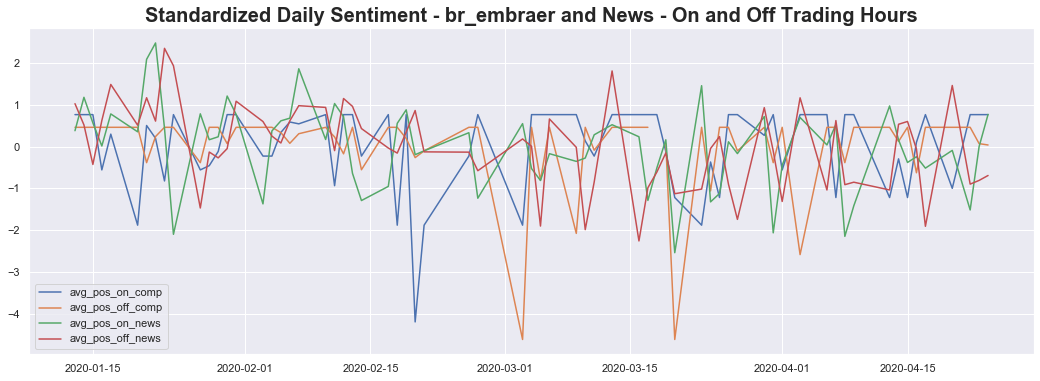

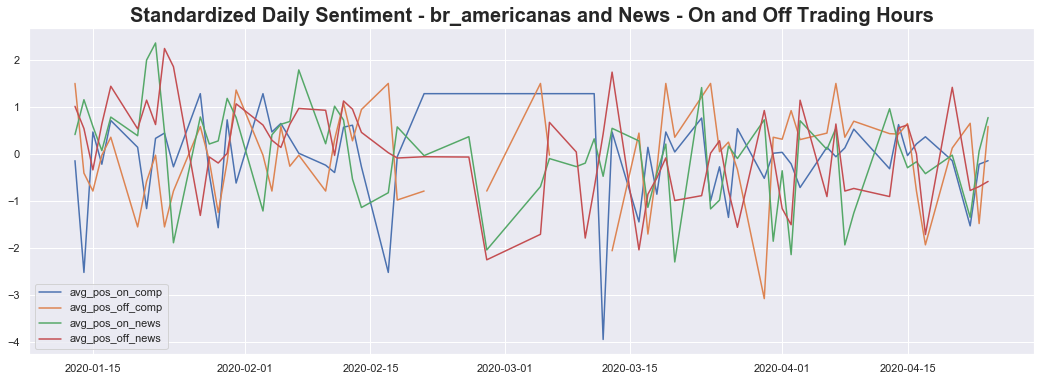

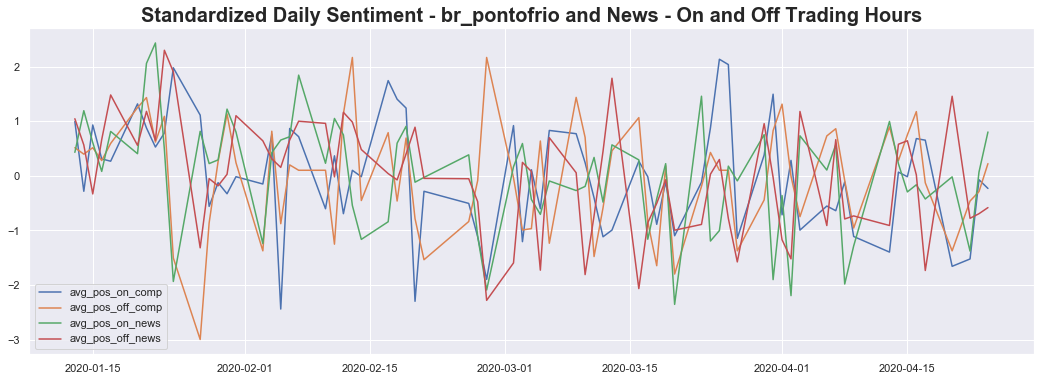

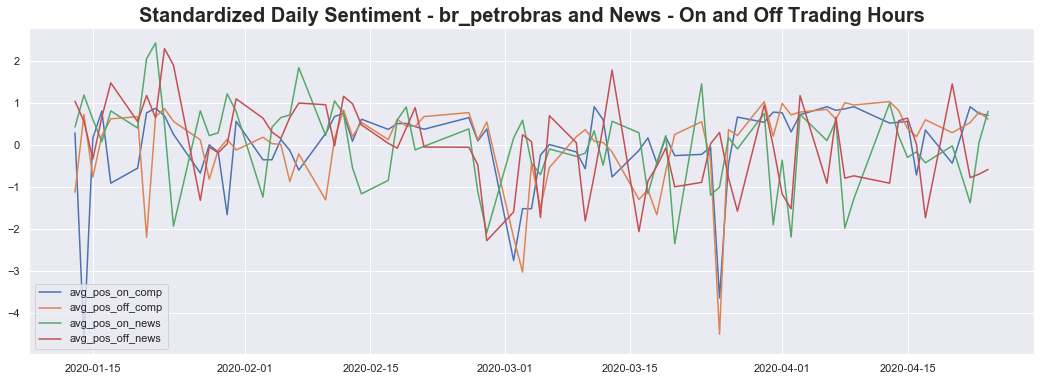

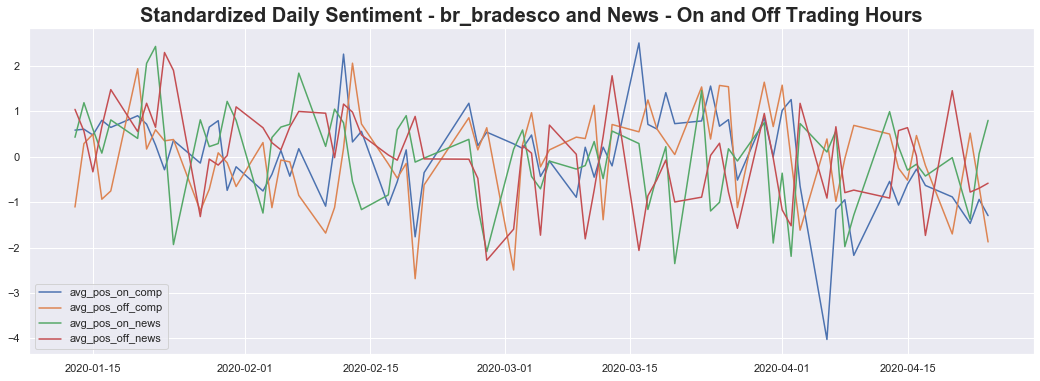

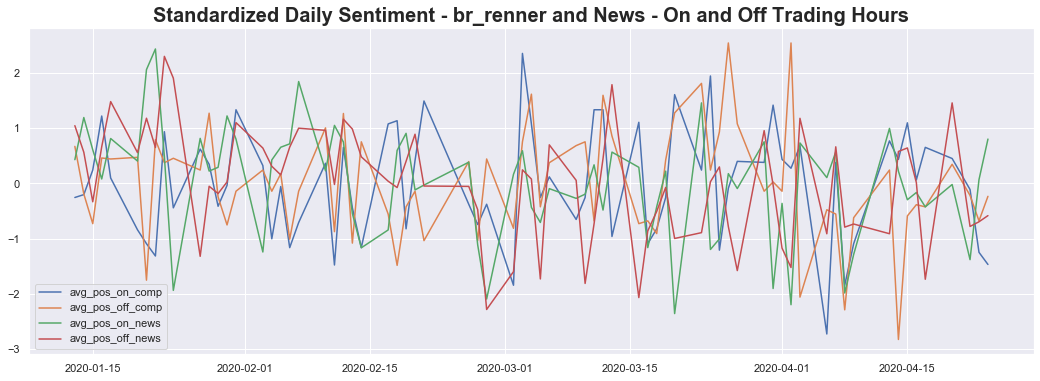

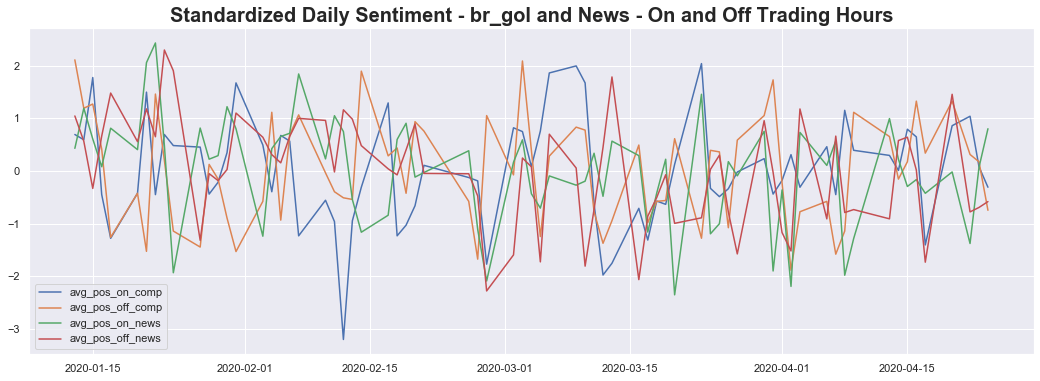

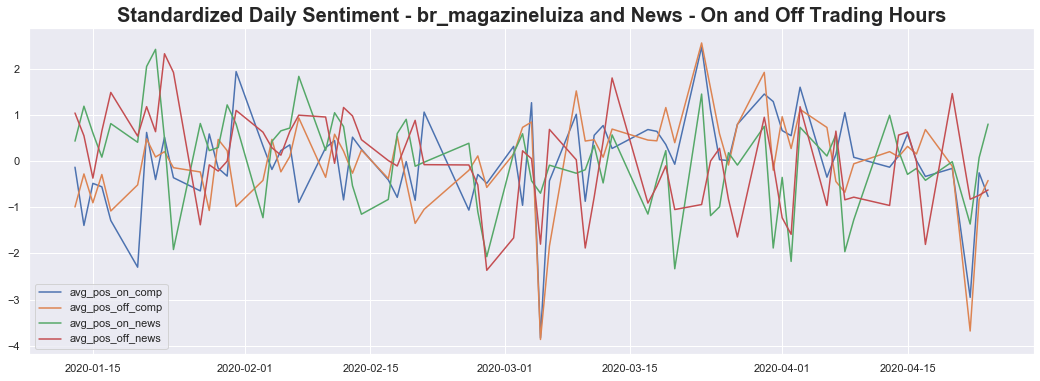

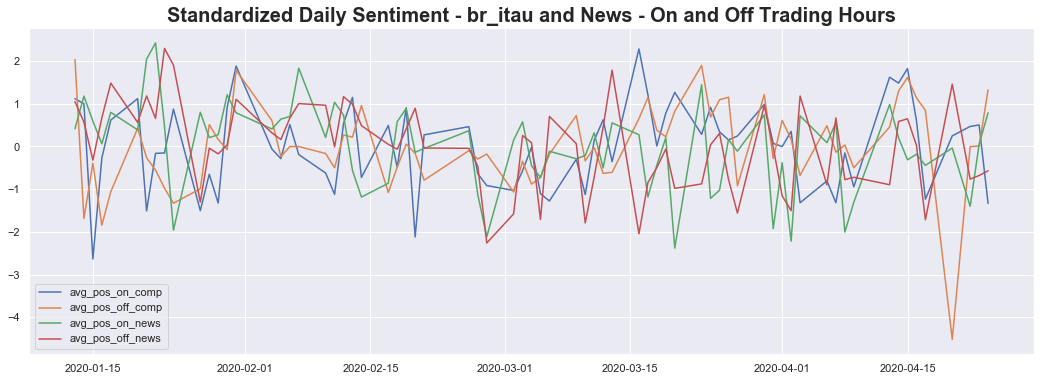

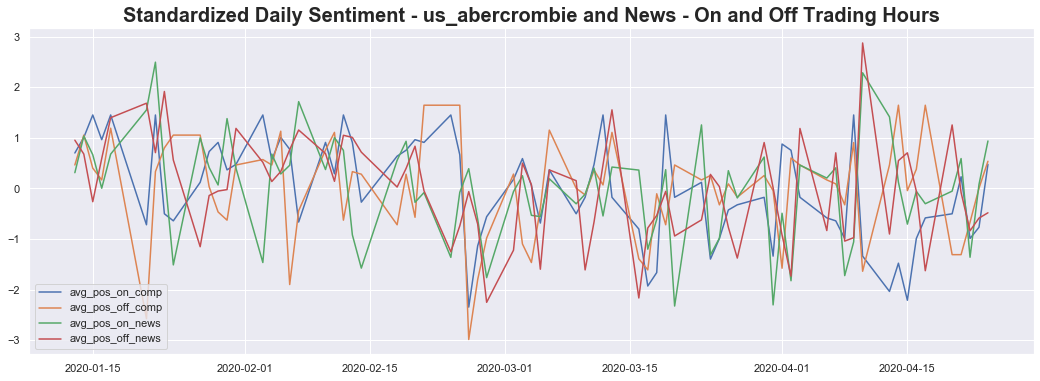

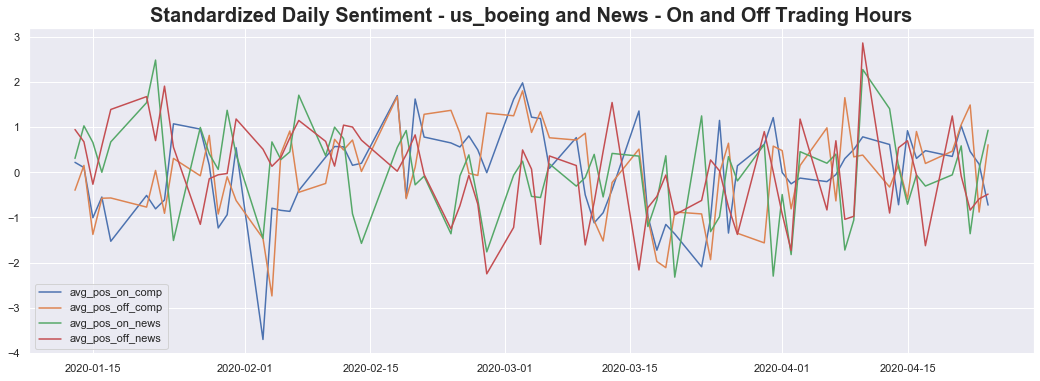

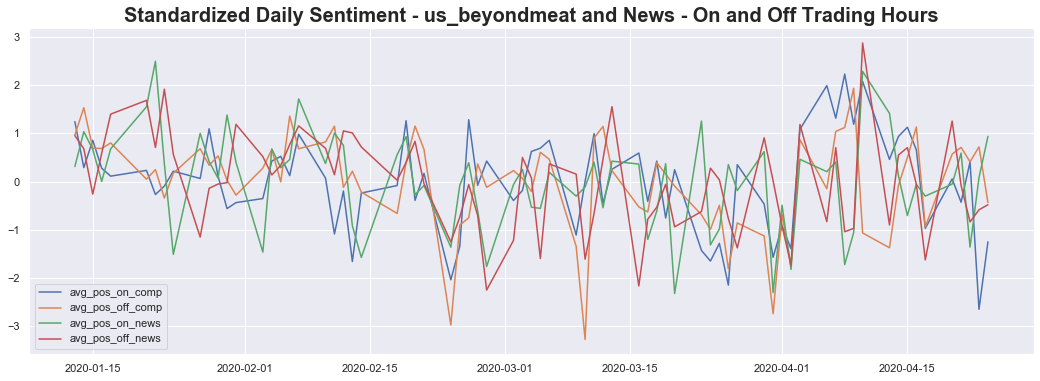

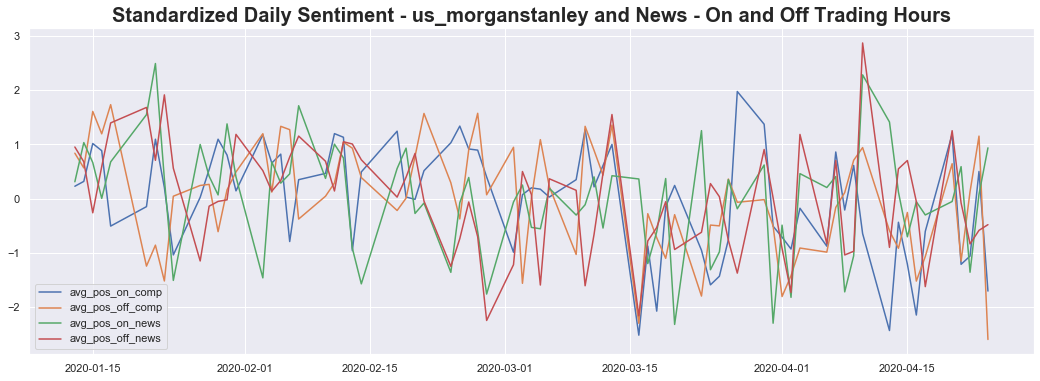

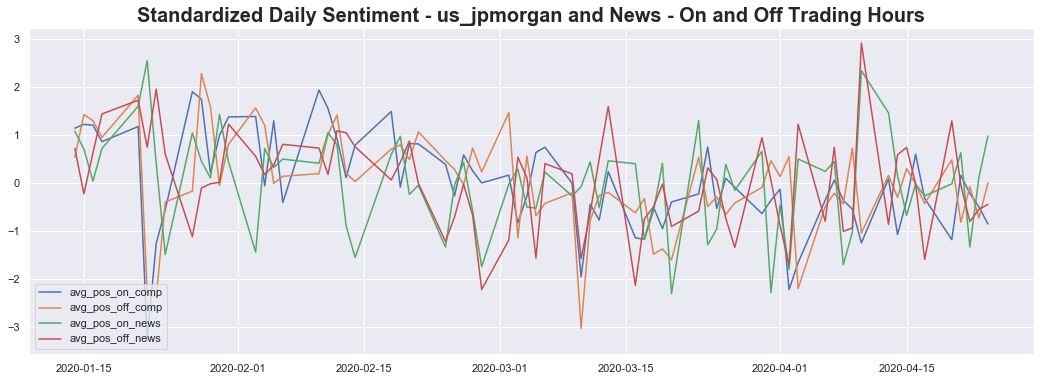

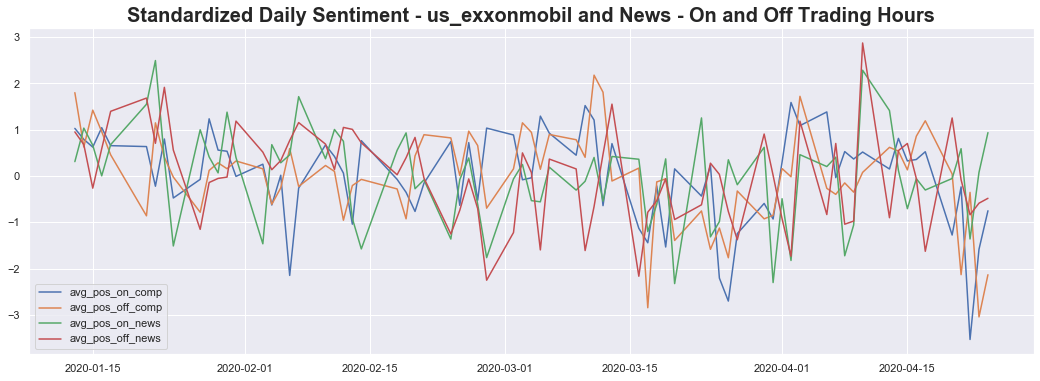

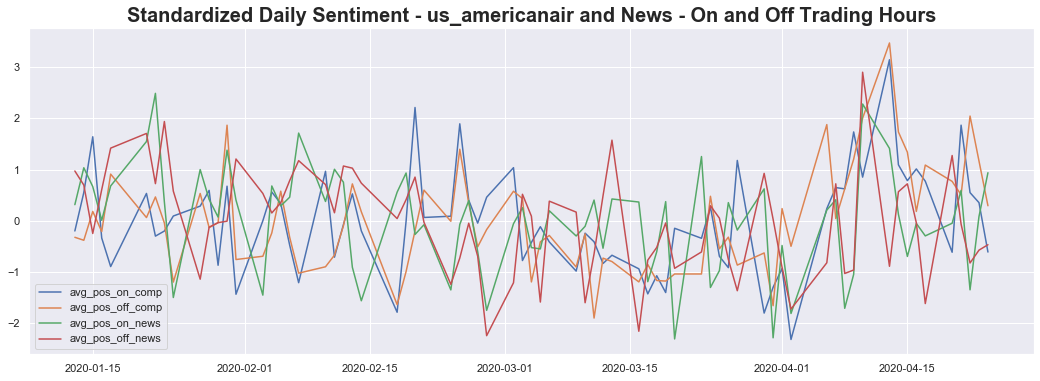

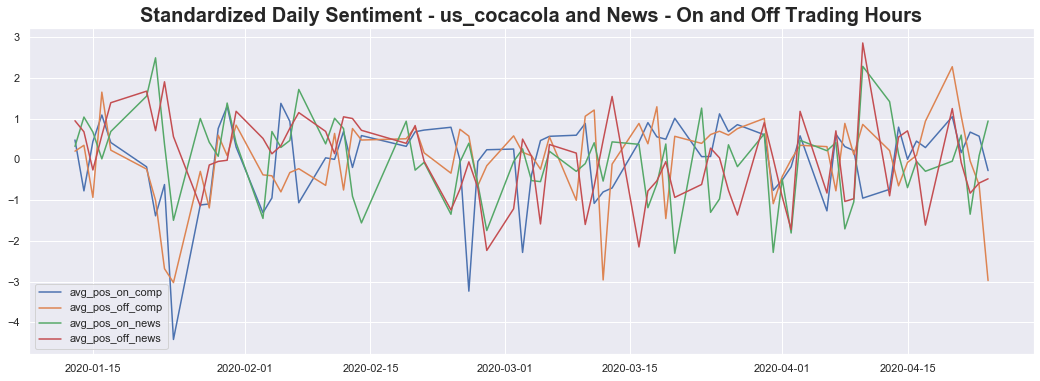

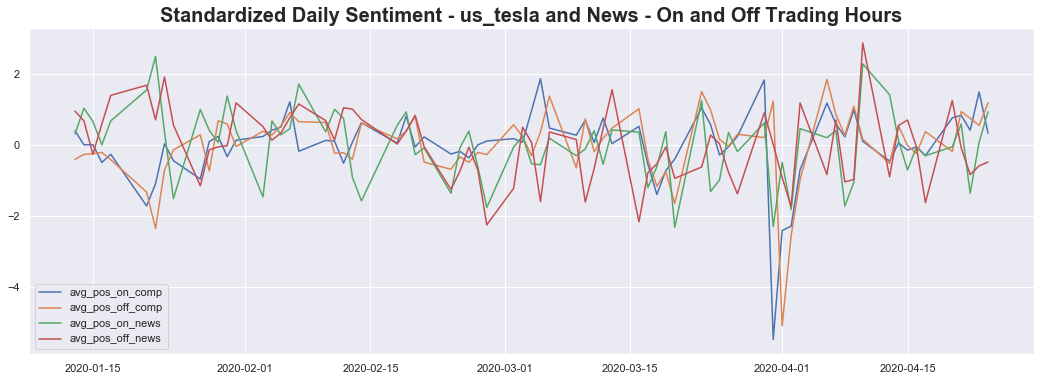

In [10]:
for company in my_companies:

    # add time blocks
    df_twitter = pd.read_pickle('Dataset_TS_01/'+company+'.pkl')
    df_twitter = period_identifier(df_twitter,company)
    df_twitter = df_twitter[['datetime',
                             'date_adj',
                             'block_15',
                             'block_60',
                             'block_on',
                             'final_pos']]
    
    # stocks
    if company[:2]=='us':
        df_stocks = pd.read_csv('Dataset_API_Daily/'+company+'.csv',header=None)
        df_news = df_news_us
    else:
        df_stocks = pd.read_csv('Dataset_API_Daily/'+company+'.csv',header=None)
        df_news = df_news_br
    
    # merge data
    df_twitter = return_df_twitter(df_twitter)
    df_stocks = return_df_stocks(df_stocks)
    
    # merge
    df1 = df_twitter.merge(df_news,left_index=True,right_index=True,how='left',suffixes=('_comp', '_news'))
    df2 = df_stocks.merge(df_stocks.shift(1),left_index=True,right_index=True, how='left',suffixes=('_lag0', '_lag1'))
    df = df2.merge(df1,left_index=True,right_index=True, how='left')
    df = df.dropna()
    
    plot_sentiment(df1,company)

    df.to_pickle('Dataset_ToModel_Daily/'+company+'.pkl')

In [50]:
summary=[]

my_c = my_companies+['br_valor','us_wsj']

for company in my_c:
    
    df = pd.read_pickle('Dataset_TS_01/'+company+'.pkl') 
    df = period_identifier(df,company)
    df = df[['final_pos','block_on']]
    df['final_neg'] = 1 - df['final_pos']
    on = df[df['block_on']==1]
    off = df[df['block_on']==0]

    sup = [sum(on['final_pos']),sum(on['final_neg']),sum(off['final_pos']),sum(off['final_neg'])]
    
    summary.append(sup)

In [51]:
pd.DataFrame(summary,index=my_c,columns=['pos_on','neg_off','pos_off','neg_off'])

,pos_on,neg_off,pos_off,neg_off
br_embraer,941,70,1144,93
br_americanas,1224,404,2622,897
br_pontofrio,2564,875,2685,821
br_petrobras,10756,1497,21187,3190
br_bradesco,12092,4208,15634,3484
br_renner,1644,636,2603,1136
br_gol,4037,1309,5779,1918
br_magazineluiza,10962,4322,39643,20598
br_itau,48239,8762,105258,13192
us_abercrombie,659,321,1727,816


### Financial data (intraday)

my_companies = ['br_embraer',
                'br_americanas',
                'br_pontofrio',
                'br_petrobras',
                'br_bradesco',
                'br_renner',
                'br_gol',
                'br_magazineluiza',
                'br_itau',
                'us_abercrombie',
                'us_boeing',
                'us_beyondmeat',
                'us_morganstanley',
                'us_jpmorgan',
                'us_exxonmobil',
                'us_americanair',
                'us_cocacola',
                'us_tesla',
                'us_wsj']

my_companies = my_companies[10:]

for company in my_companies:
    
    print(company)

    # load data, name columns
    df = pd.read_csv('Dataset_MSN_15/'+company+'.csv',
                     header=None,
                     names=['datetime','high','low','open','close','volume'],
                     dtype={0: str})

    # drop duplicates
    print(df.shape)
    df = df.drop_duplicates(['datetime'])
    print(df.shape)

    # add columns
    df = time_maker(df,company)
    df = df[['datetime','date_adj','block_15','block_60','block_on','high','low','open','close','volume']]
    
    df['high']= [int(vol.replace(".","")) if type(vol) == str else vol for vol in df_stocks.high]
    df['low']= [int(vol.replace(".","")) if type(vol) == str else vol for vol in df_stocks.low]
    df['open']= [int(vol.replace(".","")) if type(vol) == str else vol for vol in df_stocks.open]
    df['close']= [int(vol.replace(".","")) if type(vol) == str else vol for vol in df_stocks.close]
    df['volume']= [int(vol.replace(".","")) if type(vol) == str else vol for vol in df_stocks.volume]
    
    # filter variables
    df[['datetime','date_adj','high','low','open','close','volume','block_15','block_60','block_on']]

    df.to_pickle('Dataset_TS_FIN_01/'+company+'.pkl')
    
    print('------------')